Tutorials:

https://www.youtube.com/watch?v=u1loyDCoGbE


https://www.youtube.com/watch?v=GAYJ81M58y8
https://www.epfl.ch/labs/cvlab/data/data-em/
https://github.com/bnsreenu/python_for_microscopists

In [ ]:
https://colab.research.google.com/github/constantinpape/torch-em/blob/main/experiments/2D-UNet-Training.ipynb

In [ ]:
https://colab.research.google.com/github/usuyama/pytorch-unet/blob/master/pytorch_unet_resnet18_colab.ipynb

In [2]:
!nvidia-smi

Thu Nov 16 21:14:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.70       Driver Version: 517.70       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    10W /  N/A |    292MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install --no-deps kornia
!pip install --no-deps git+https://github.com/constantinpape/torch-em

  Cloning https://github.com/constantinpape/torch-em to c:\users\surya\appdata\local\temp\pip-req-build-pd9mlw6l
  Resolved https://github.com/constantinpape/torch-em to commit 3734d190976505529ae02b80bdebc680dcdb1c89
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/constantinpape/torch-em 'C:\Users\surya\AppData\Local\Temp\pip-req-build-pd9mlw6l'


In [ ]:
!conda update -n base -c defaults conda
!conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.7 -c pytorch -c nvidia
!conda install -c pytorch -c conda-forge python-elf dask bioimageio.core


In [ ]:
import numpy as np
import torch.nn as nn
import torch_em
import torch_em.data.datasets as torchem_data
from torch_em.model import UNet2d
from torch_em.util.debug import check_loader, check_trainer

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2951619851970076221
xla_global_id: -1
]


In [33]:
def image_generator(files, images_path ,annotations_path,batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'{annotations_path}/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'{images_path}/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      


batch_size = 32

all_files = os.listdir('datasets//images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files,'datasets//images', 'datasets//annotations', batch_size = batch_size)
test_generator  = image_generator(test_files, 'datasets//images', 'datasets//annotations', batch_size = batch_size)


In [34]:
x, y= next(train_generator)

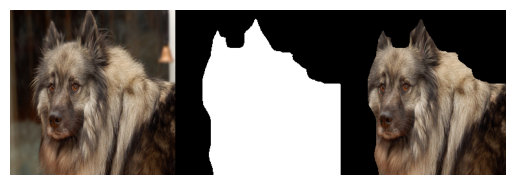

In [35]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [36]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [37]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [38]:
model = unet()

In [53]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning('datasets//images')]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
    def __init__(self, datapath):
        self.datapath = datapath

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'{self.datapath}/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

C:\Users\surya\AppData\Local\Temp\ipykernel_22252\4219506397.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


i= 1 loss= 0.5354042053222656 val_loss= 0.47139063477516174 mean_iou= 0.007979401387274265 val_mean_iou= 0.0008312404388561845
1/1 [==============================] - 1s 824ms/step


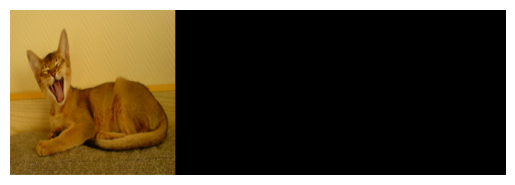

i= 2 loss= 0.48574474453926086 val_loss= 0.4320298135280609 mean_iou= 0.3301452100276947 val_mean_iou= 0.47858676314353943
1/1 [==============================] - 0s 94ms/step


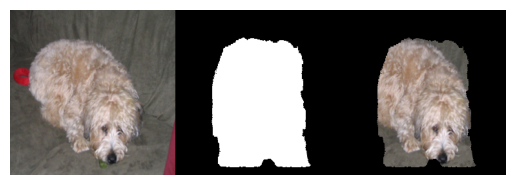

i= 3 loss= 0.44004586338996887 val_loss= 0.4392630457878113 mean_iou= 0.45913997292518616 val_mean_iou= 0.5334417819976807
1/1 [==============================] - 0s 86ms/step


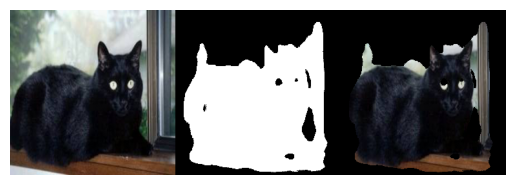

i= 4 loss= 0.39951908588409424 val_loss= 0.35125041007995605 mean_iou= 0.5118347406387329 val_mean_iou= 0.5697707533836365
1/1 [==============================] - 0s 73ms/step


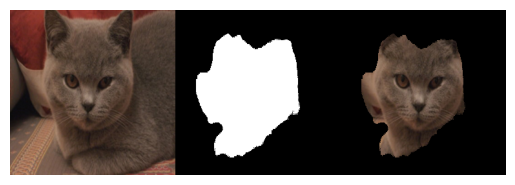

i= 5 loss= 0.36821314692497253 val_loss= 0.30358392000198364 mean_iou= 0.5498947501182556 val_mean_iou= 0.6168818473815918
1/1 [==============================] - 0s 98ms/step


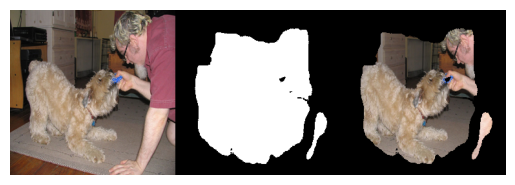

i= 6 loss= 0.3504352867603302 val_loss= 0.3596099615097046 mean_iou= 0.5827427506446838 val_mean_iou= 0.6090795993804932
1/1 [==============================] - 0s 103ms/step


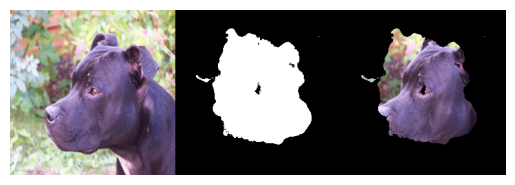

i= 7 loss= 0.316158652305603 val_loss= 0.31862327456474304 mean_iou= 0.6208581328392029 val_mean_iou= 0.590608537197113
1/1 [==============================] - 0s 82ms/step


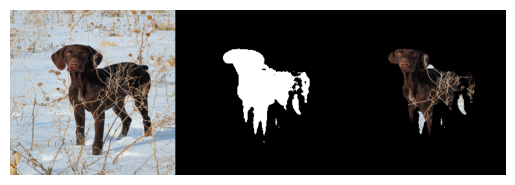

i= 8 loss= 0.29839813709259033 val_loss= 0.29448139667510986 mean_iou= 0.6402794718742371 val_mean_iou= 0.6800079345703125
1/1 [==============================] - 0s 35ms/step


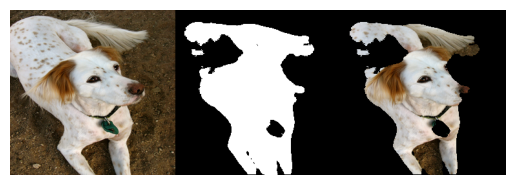

i= 9 loss= 0.27957838773727417 val_loss= 0.23822134733200073 mean_iou= 0.6643268465995789 val_mean_iou= 0.6954178214073181
1/1 [==============================] - 0s 34ms/step


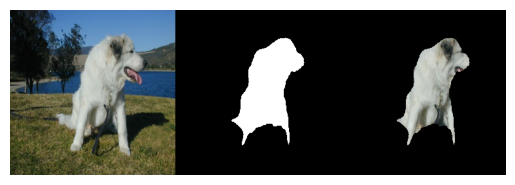

i= 10 loss= 0.2686385214328766 val_loss= 0.24124743044376373 mean_iou= 0.6843225955963135 val_mean_iou= 0.7113341689109802
1/1 [==============================] - 0s 35ms/step


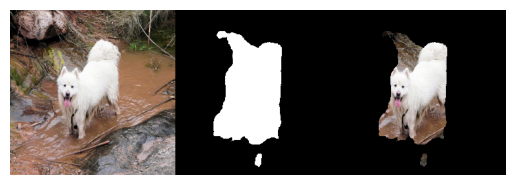

i= 11 loss= 0.25127676129341125 val_loss= 0.24101652204990387 mean_iou= 0.7029641270637512 val_mean_iou= 0.7020956873893738
1/1 [==============================] - 0s 38ms/step


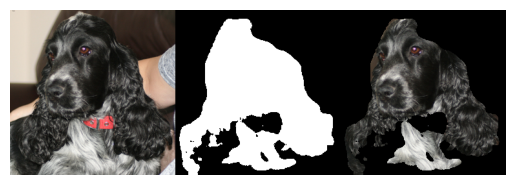

i= 12 loss= 0.2379319667816162 val_loss= 0.3029659390449524 mean_iou= 0.7134554982185364 val_mean_iou= 0.6417089700698853
1/1 [==============================] - 0s 30ms/step


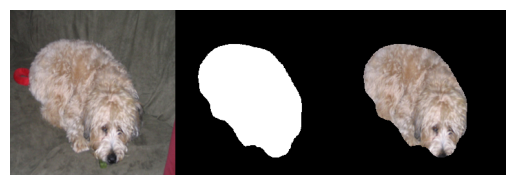

i= 13 loss= 0.22698533535003662 val_loss= 0.1933155506849289 mean_iou= 0.7313307523727417 val_mean_iou= 0.7601566314697266
1/1 [==============================] - 0s 38ms/step


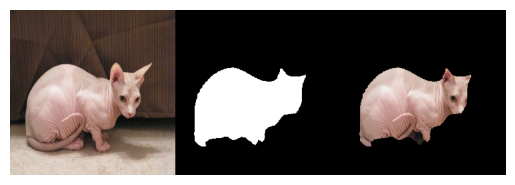

i= 14 loss= 0.21585145592689514 val_loss= 0.2758100926876068 mean_iou= 0.7431397438049316 val_mean_iou= 0.6905295848846436
1/1 [==============================] - 0s 32ms/step


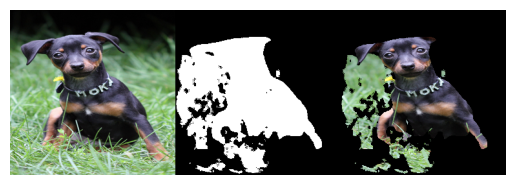

i= 15 loss= 0.20433206856250763 val_loss= 0.23398037254810333 mean_iou= 0.7532188892364502 val_mean_iou= 0.7140950560569763
1/1 [==============================] - 0s 31ms/step


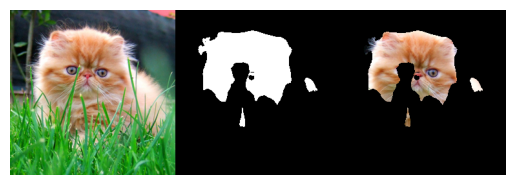

i= 16 loss= 0.19607514142990112 val_loss= 0.22518938779830933 mean_iou= 0.7660442590713501 val_mean_iou= 0.7241384983062744
1/1 [==============================] - 0s 32ms/step


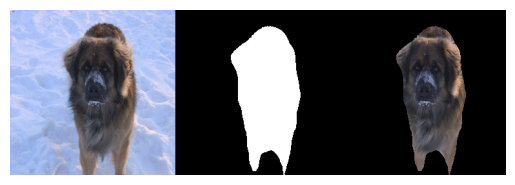

i= 17 loss= 0.18869678676128387 val_loss= 0.20292256772518158 mean_iou= 0.7710861563682556 val_mean_iou= 0.7508333325386047
1/1 [==============================] - 0s 35ms/step


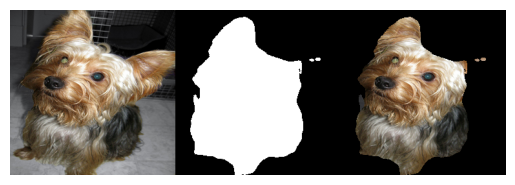

i= 18 loss= 0.17942914366722107 val_loss= 0.2138679474592209 mean_iou= 0.7824152708053589 val_mean_iou= 0.741969645023346
1/1 [==============================] - 0s 35ms/step


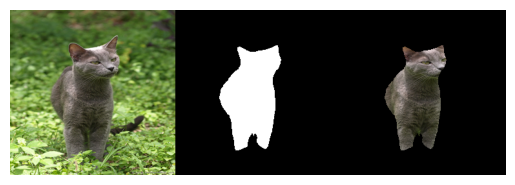

i= 19 loss= 0.17259031534194946 val_loss= 0.24839147925376892 mean_iou= 0.7918739318847656 val_mean_iou= 0.7405462265014648
1/1 [==============================] - 0s 33ms/step


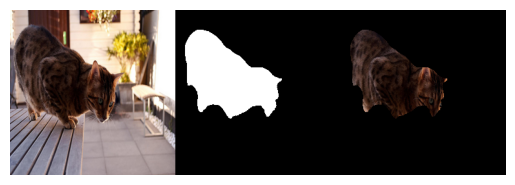

i= 20 loss= 0.1691933423280716 val_loss= 0.19810208678245544 mean_iou= 0.7932037711143494 val_mean_iou= 0.7580263018608093
1/1 [==============================] - 0s 35ms/step


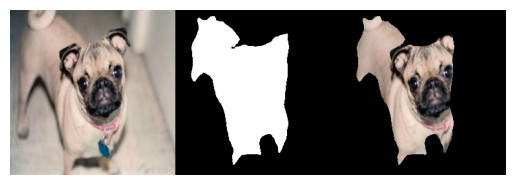

i= 21 loss= 0.15467360615730286 val_loss= 0.2022981196641922 mean_iou= 0.808822751045227 val_mean_iou= 0.770359218120575
1/1 [==============================] - 0s 35ms/step


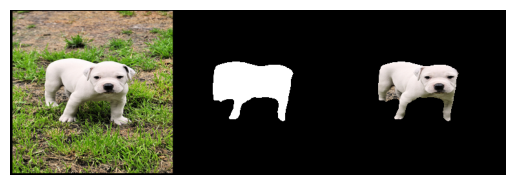

i= 22 loss= 0.1523347944021225 val_loss= 0.19800697267055511 mean_iou= 0.8129125237464905 val_mean_iou= 0.7655864953994751
1/1 [==============================] - 0s 37ms/step


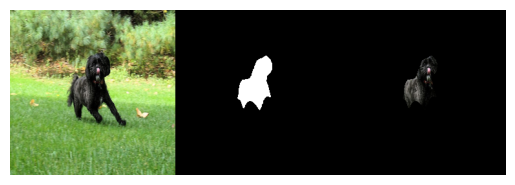

i= 23 loss= 0.14856131374835968 val_loss= 0.2407253384590149 mean_iou= 0.8164201974868774 val_mean_iou= 0.7366387844085693
1/1 [==============================] - 0s 34ms/step


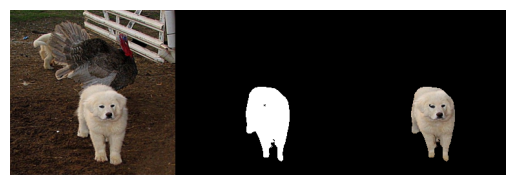

i= 24 loss= 0.14025913178920746 val_loss= 0.177957221865654 mean_iou= 0.8264535665512085 val_mean_iou= 0.7888628244400024
1/1 [==============================] - 0s 34ms/step


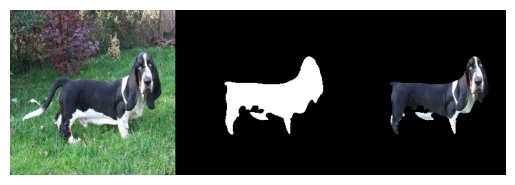

i= 25 loss= 0.13939042389392853 val_loss= 0.16612643003463745 mean_iou= 0.8276367783546448 val_mean_iou= 0.769146740436554
1/1 [==============================] - 0s 32ms/step


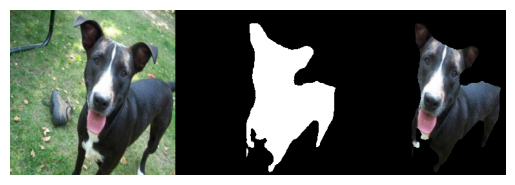

i= 26 loss= 0.1296122521162033 val_loss= 0.18299750983715057 mean_iou= 0.8365549445152283 val_mean_iou= 0.788368284702301
1/1 [==============================] - 0s 37ms/step


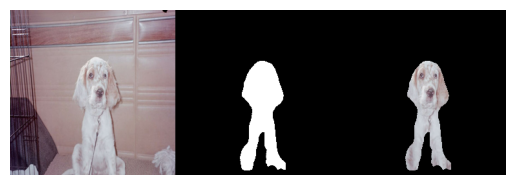

i= 27 loss= 0.13018500804901123 val_loss= 0.1959775984287262 mean_iou= 0.8401637077331543 val_mean_iou= 0.7553619742393494
1/1 [==============================] - 0s 39ms/step


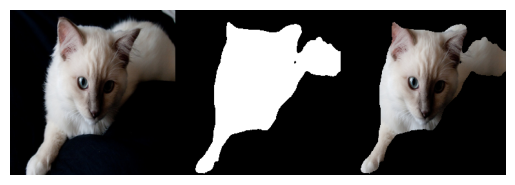

i= 28 loss= 0.12479366362094879 val_loss= 0.16958695650100708 mean_iou= 0.8432711958885193 val_mean_iou= 0.8038255572319031
1/1 [==============================] - 0s 32ms/step


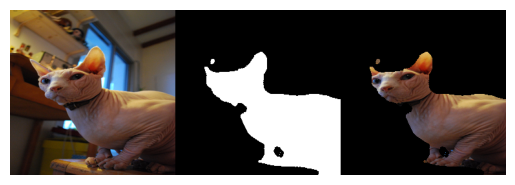

i= 29 loss= 0.12050849944353104 val_loss= 0.15939554572105408 mean_iou= 0.8496890664100647 val_mean_iou= 0.7982620596885681
1/1 [==============================] - 0s 42ms/step


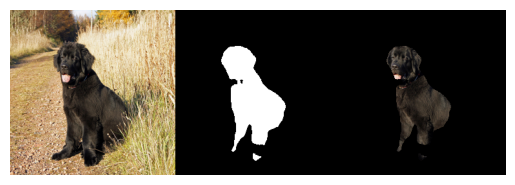

i= 30 loss= 0.11478551477193832 val_loss= 0.18980301916599274 mean_iou= 0.8555457592010498 val_mean_iou= 0.7873523235321045
1/1 [==============================] - 0s 32ms/step


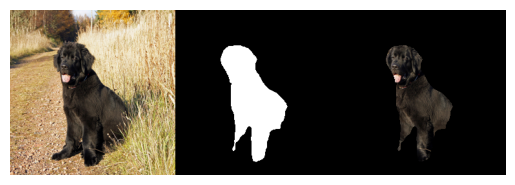

In [54]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

1/1 [==============================] - 0s 33ms/step


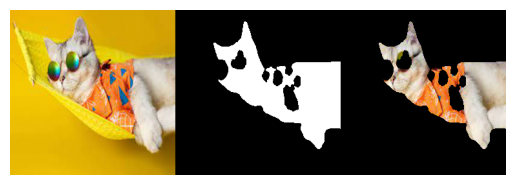

In [55]:
raw = Image.open('datasets//unseen_data//images.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

1/1 [==============================] - 0s 31ms/step


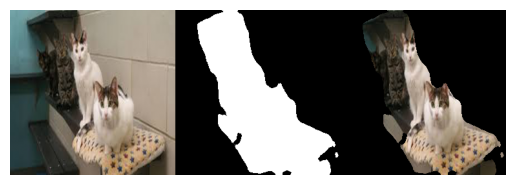

In [56]:
raw = Image.open('datasets//unseen_data//images2.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()